In [48]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ydata_profiling import ProfileReport

df = pd.read_csv("data/gold_2.csv")
pd.set_option('display.max_columns', None)  

In [49]:
# df_2010 = df[~df['InvoiceDate'].str.contains('2011')]
# df_2011 = df[~df['InvoiceDate'].str.contains('2009|2010')]

# prend seulement les dates de 2009 et decembre 2010 separer le data frame en deu
df_2010 = df[(df['InvoiceDate'] >= '2009-12-01') & (df['InvoiceDate'] < '2010-12-01')]
df_2011 = df[df['InvoiceDate'] >= '2010-12-01']

c:\Users\impej\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\impej\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\impej\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\impej\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\impej\miniconda3\lib\site-packages\sklearn\

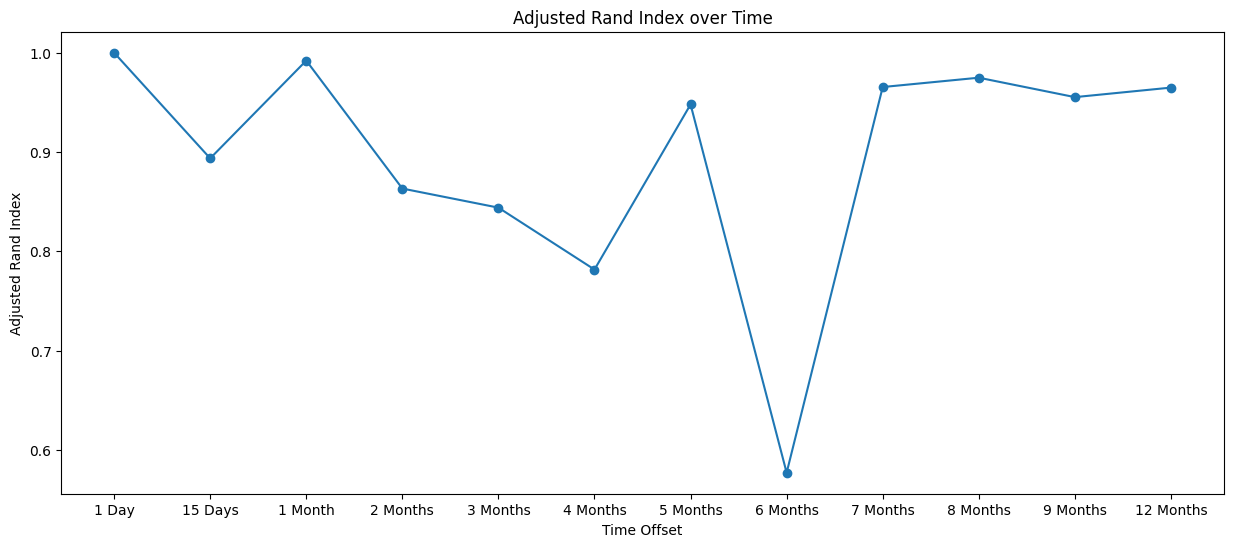

In [63]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import pandas as pd

# Ensure that InvoiceDate is in datetime format
df_2010['InvoiceDate'] = pd.to_datetime(df_2010['InvoiceDate'])
df_2011['InvoiceDate'] = pd.to_datetime(df_2011['InvoiceDate'])

# Define the list of time offsets
time_offsets = [
    pd.DateOffset(days=1),
    pd.DateOffset(days=15),
    pd.DateOffset(months=1),
    pd.DateOffset(months=2),
    pd.DateOffset(months=3),
    pd.DateOffset(months=4),
    pd.DateOffset(months=5),
    pd.DateOffset(months=6),
    pd.DateOffset(months=7),
    pd.DateOffset(months=8),
    pd.DateOffset(months=9),
    pd.DateOffset(years=1),
]

# Initialize a list to store the ARI values
ari_values = []

# Define the initial labels as None
labels_prev = None

# For each time offset...
for offset in time_offsets:
    # Add the data from the offset to the 2009-2010 dataframe
    offset_date = df_2011['InvoiceDate'].min() + offset
    df_2009_2010_extended = pd.concat([df_2010, df_2011[df_2011['InvoiceDate'] <= offset_date]])

    # Calculate the snapshot date for RFM calculations
    snapshot_date = df_2009_2010_extended['InvoiceDate'].max()

    # Calculate RFM values
    rfm = df_2009_2010_extended.groupby(['Customer ID']).agg({
    'Recency': 'sum',
    'Frequency_reel': 'count',
    'Montant': 'sum'})

    # Normalize RFM values
    rfm_normalized = (rfm - rfm.mean()) / rfm.std()

    # Apply K-Means Clustering to segment customers
    kmeans = KMeans(n_clusters=3, random_state=42) 
    kmeans.fit(rfm_normalized)
    rfm['Cluster'] = kmeans.labels_

    # If this is not the first iteration, calculate the Adjusted Rand Index
    if labels_prev is not None:
        # Keep only common customers in both dataframes
        common_customers = set(rfm_prev.index).intersection(set(rfm.index))
        labels_prev_common = labels_prev[rfm_prev.index.isin(common_customers)]
        labels_common = rfm['Cluster'][rfm.index.isin(common_customers)]
        
        # Calculate the Adjusted Rand Index
        ari_common = adjusted_rand_score(labels_prev_common, labels_common)
        ari_values.append(ari_common)

    # Update the previous labels and RFM dataframe for the next iteration
    labels_prev = rfm['Cluster']
    rfm_prev = rfm

# Create a line plot of ARI values over time
plt.figure(figsize=(15, 6))
plt.plot(
    ['1 Day', '15 Days', '1 Month', '2 Months', '3 Months', '4 Months', '5 Months', '6 Months', '7 Months', '8 Months', '9 Months', '12 Months'],
    [1] + ari_values,
    '-o'
)
plt.title('Adjusted Rand Index over Time')
plt.xlabel('Time Offset')
plt.ylabel('Adjusted Rand Index')
plt.show()

In [51]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'year', 'month',
       'Price', 'Customer ID', 'Total', 'total_facture',
       'nombre_commande_client_années_2009',
       'nombre_commande_client_années_2010',
       'nombre_commande_client_années_2011',
       'nombre_commande_client_années_annulées_2009',
       'nombre_commande_client_années_annulées_2010',
       'nombre_commande_client_années_annulées_2011', 'TT_annuler',
       'Continent', 'niveau_achat', 'Recency', 'Frequency', 'Frequency_reel',
       'Montant', 'Cluster'],
      dtype='object')


In [52]:
customer_ids_2010 = df_2010['Customer ID'].unique()
customer_ids_2011 = df_2011['Customer ID'].unique()
common_customer_ids = set(customer_ids_2010).intersection(customer_ids_2011)
df_2010 = df_2010[df_2010['Customer ID'].isin(common_customer_ids)]
df_2011 = df_2011[df_2011['Customer ID'].isin(common_customer_ids)]


In [53]:
df_2010

,Invoice,StockCode,Quantity,InvoiceDate,year,month,Price,Customer ID,Total,total_facture,nombre_commande_client_années_2009,nombre_commande_client_années_2010,nombre_commande_client_années_2011,nombre_commande_client_années_annulées_2009,nombre_commande_client_années_annulées_2010,nombre_commande_client_années_annulées_2011,TT_annuler,Continent,niveau_achat,Recency,Frequency,Frequency_reel,Montant,Cluster
0,489434,85048,12,2009-12-01,2009,12,6.95,13085.0,83.4,505.30,4.0,3.0,3.0,0.0,1.0,1.0,2.0,United Kingdom,2.0,157,10.0,8.0,27639.6,1
1,489434,79323P,12,2009-12-01,2009,12,6.75,13085.0,81.0,505.30,4.0,3.0,3.0,0.0,1.0,1.0,2.0,United Kingdom,2.0,157,10.0,8.0,27639.6,1
2,489434,79323W,12,2009-12-01,2009,12,6.75,13085.0,81.0,505.30,4.0,3.0,3.0,0.0,1.0,1.0,2.0,United Kingdom,2.0,157,10.0,8.0,27639.6,1
3,489434,22041,48,2009-12-01,2009,12,2.10,13085.0,100.8,505.30,4.0,3.0,3.0,0.0,1.0,1.0,2.0,United Kingdom,2.0,157,10.0,8.0,27639.6,1
4,489434,21232,24,2009-12-01,2009,12,1.25,13085.0,30.0,505.30,4.0,3.0,3.0,0.0,1.0,1.0,2.0,United Kingdom,2.0,157,10.0,8.0,27639.6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316337,536364,21175,12,2010-11-30,2010,11,2.10,14441.0,25.2,473.53,0.0,10.0,9.0,0.0,3.0,5.0,8.0,United Kingdom,2.0,0,19.0,11.0,74258.1,1
316338,536364,21524,2,2010-11-30,2010,11,7.95,14441.0,15.9,473.53,0.0,10.0,9.0,0.0,3.0,5.0,8.0,United Kingdom,2.0,0,19.0,11.0,74258.1,1
316339,536364,21098,12,2010-11-30,2010,11,1.25,14441.0,15.0,473.53,0.0,10.0,9.0,0.0,3.0,5.0,8.0,United Kingdom,2.0,0,19.0,11.0,74258.1,1
316340,536364,21181,24,2010-11-30,2010,11,2.10,14441.0,50.4,473.53,0.0,10.0,9.0,0.0,3.0,5.0,8.0,United Kingdom,2.0,0,19.0,11.0,74258.1,1


In [54]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# # Normalisation des données
# scaler = StandardScaler()
# data = scaler.fit_transform(df_2010[['Recency', 'Frequency_reel', 'Montant']])

# # Détermination du nombre optimal de clusters en utilisant la méthode du coude
# wcss = []
# for i in range(1, 15):
#  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
#  kmeans.fit(data)
#  wcss.append(kmeans.inertia_)

# plt.figure(figsize=(12,6))
# plt.plot(range(1, 15), wcss)
# plt.title('Méthode du coude')
# plt.xlabel('Nombre de clusters')
# plt.ylabel('WCSS')
# plt.show()

# # Entraînement du modèle KMeans avec le nombre optimal de clusters
# n_clusters = 4 # Remplacez cette valeur par le nombre optimal de clusters déterminé à l'aide de la méthode du coude
# kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
# pred_y = kmeans.fit_predict(data)

# # Visualisation des clusters
# plt.figure(figsize=(12,6))
# plt.scatter(data[pred_y == 0, 0], data[pred_y == 0, 1], s=50, c='red', label='Cluster 1', alpha=0.5)
# plt.scatter(data[pred_y == 1, 0], data[pred_y == 1, 1], s=50, c='blue', label='Cluster 2', alpha=0.5)
# plt.scatter(data[pred_y == 2, 0], data[pred_y == 2, 1], s=50, c='green', label='Cluster 3', alpha=0.5)
# plt.scatter(data[pred_y == 3, 0], data[pred_y == 3, 1], s=50, c='yellow', label='Cluster 4', alpha=0.5)

# # plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
# plt.title('Clusters de clients')
# plt.xlabel('Recency')
# plt.ylabel('Frequency_reel')
# plt.legend()
# plt.show()

In [55]:
# print(f"Longueur des étiquettes de cluster réelles: {len(labels_true)}")
# print(f"Longueur des étiquettes de cluster prédites: {len(labels_pred)}")

In [56]:
# from sklearn.metrics import adjusted_rand_score

# # Remplacez les valeurs ci-dessous par les étiquettes de vos clusters
# labels_true = [...] # Étiquettes de cluster réelles
# labels_pred = kmeans.labels_ # Étiquettes de cluster prédites

# # Calcul du score ARI
# score = adjusted_rand_score(labels_true, labels_pred)

# print(f"Le score ARI est: {score}")


In [57]:
# print(f"Longueur des étiquettes de cluster réelles: {len(labels_true)}")
# print(f"Longueur des étiquettes de cluster prédites: {len(labels_pred)}")